In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [2]:
hf = pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [3]:
cont_vars = ["ejection_fraction", "serum_creatinine", 
             "serum_sodium", "platelets","creatinine_phosphokinase"]

hf_cont = hf.melt(id_vars="DEATH_EVENT", 
                  value_vars=cont_vars,
                  var_name="variable", value_name="value")

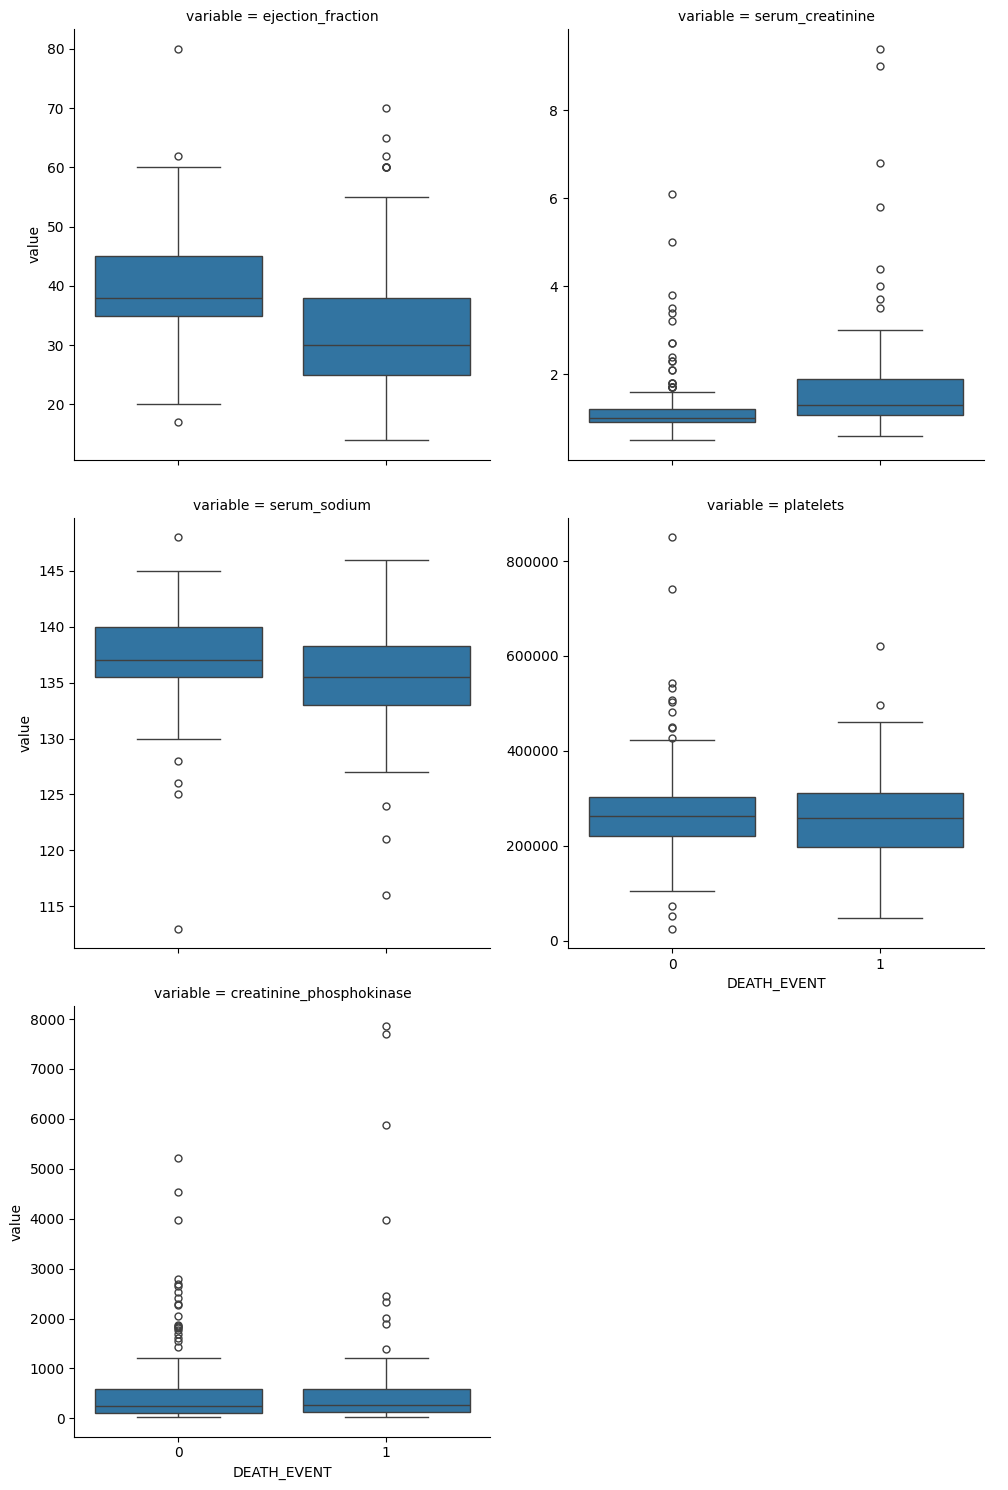

In [47]:
sns.catplot(
    data=hf_cont, 
    x="DEATH_EVENT", 
    y="value", 
    col="variable",
    kind="box", 
    col_wrap=2,
    sharey=False
)

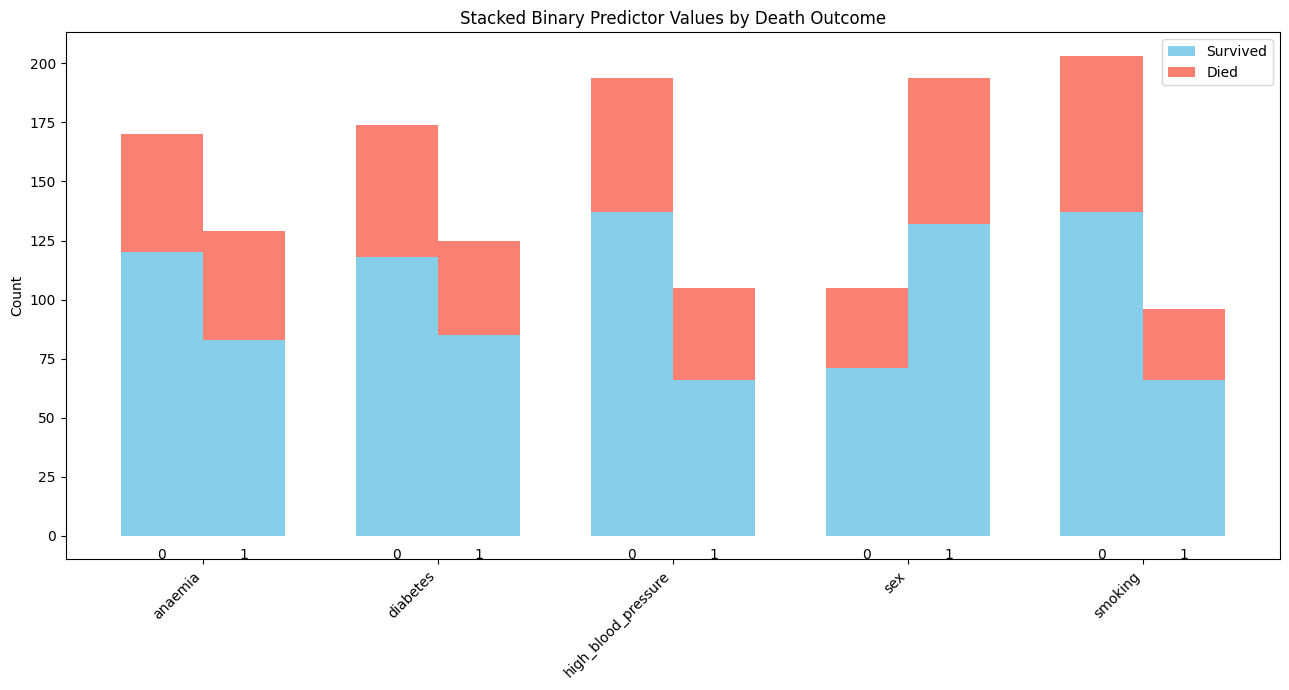

In [16]:
binary_vars = ["anaemia", "diabetes", "high_blood_pressure", "smoking", "sex"]

# melt
hf_bin = hf.melt(
    id_vars="DEATH_EVENT",
    value_vars=binary_vars,
    var_name="variable",
    value_name="predictor_value"
)

# grouped counts
counts = (
    hf_bin.groupby(["variable", "predictor_value", "DEATH_EVENT"])
          .size()
          .reset_index(name="count")
)

variables = counts["variable"].unique()
predictor_levels = [0, 1]

plt.figure(figsize=(13, 7))

bar_width = 0.35
x = np.arange(len(variables))

for i, pv in enumerate(predictor_levels):

    sub = counts[counts["predictor_value"] == pv]
    sub = sub.pivot(index="variable", columns="DEATH_EVENT", values="count").fillna(0)
    sub = sub.reindex(variables)

    survived = sub[0].values
    died = sub[1].values

    # plot stacked bars
    plt.bar(
        x + (i - 0.5)*bar_width,
        survived,
        width=bar_width,
        color="skyblue"
    )
    plt.bar(
        x + (i - 0.5)*bar_width,
        died,
        bottom=survived,
        width=bar_width,
        color="salmon"
    )

    # 0/1 labels for each variable
    for xi in x:
        plt.text(
            xi + (i - 0.5)*bar_width,
            -5,               # a little below the x axis
            str(pv),
            ha='center',
            va='top',
            fontsize=10
        )

# Set x-axis labels (variable names)
plt.xticks(x, variables, rotation=45, ha='right')

plt.ylabel("Count")
plt.title("Stacked Binary Predictor Values by Death Outcome")
plt.legend(["Survived", "Died"])
plt.ylim(bottom=-10)  # make room below for 0/1 labels

plt.tight_layout()
plt.show()


In [19]:
hf_bin


,DEATH_EVENT,variable,predictor_value
0,1,anaemia,0
1,1,anaemia,0
2,1,anaemia,0
3,1,anaemia,1
4,1,anaemia,1
...,...,...,...
1490,0,sex,1
1491,0,sex,0
1492,0,sex,0
1493,0,sex,1


In [50]:
for var in binary_vars:
    print(pd.crosstab(hf[var], hf["DEATH_EVENT"], normalize="index"))
    print()

DEATH_EVENT         0         1
anaemia                        
0            0.705882  0.294118
1            0.643411  0.356589

DEATH_EVENT         0         1
diabetes                       
0            0.678161  0.321839
1            0.680000  0.320000

DEATH_EVENT                 0         1
high_blood_pressure                    
0                    0.706186  0.293814
1                    0.628571  0.371429

DEATH_EVENT         0         1
smoking                        
0            0.674877  0.325123
1            0.687500  0.312500

DEATH_EVENT         0         1
sex                            
0            0.676190  0.323810
1            0.680412  0.319588



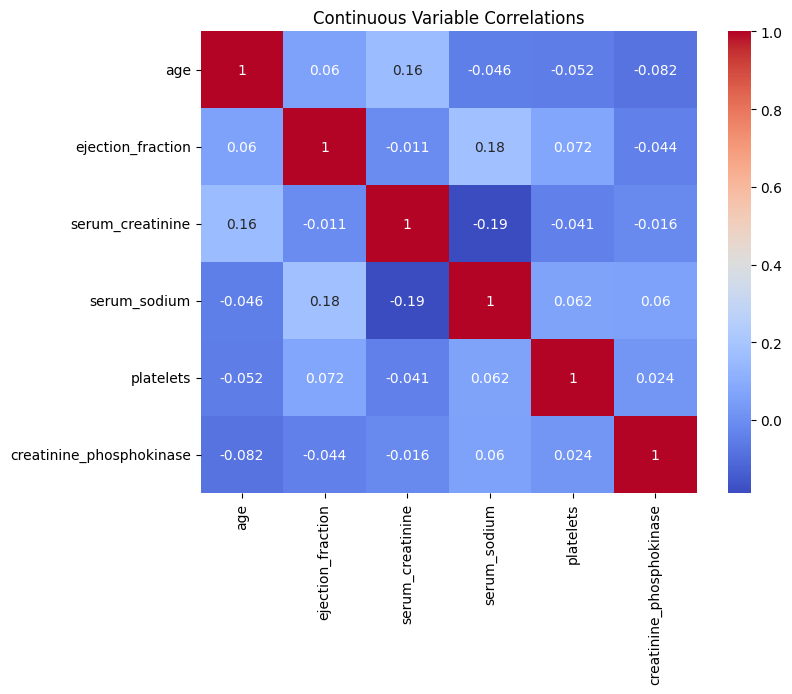

In [51]:
corr = hf[["age", "ejection_fraction", "serum_creatinine",
           "serum_sodium", "platelets", "creatinine_phosphokinase"]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Continuous Variable Correlations")
plt.show()


In [52]:
# FREQUENTIST
import statsmodels.formula.api as smf

vars_to_test = ["age", "ejection_fraction", "serum_creatinine", 
                "serum_sodium", "platelets", "creatinine_phosphokinase",
                "diabetes", "high_blood_pressure", "anaemia", "smoking", "sex"]

results = []

for v in vars_to_test:
    formula = f"DEATH_EVENT ~ {v}"
    model = smf.logit(formula, data=hf).fit(disp=False)
    coef = model.params[1]
    pval = model.pvalues[1]
    results.append((v, coef, pval))

importance = pd.DataFrame(results, columns=["variable", "coef", "p_value"])
importance.sort_values("p_value", inplace=True)
importance


/tmp/ipykernel_723/1011032651.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = model.params[1]
/tmp/ipykernel_723/1011032651.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pval = model.pvalues[1]
/tmp/ipykernel_723/1011032651.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = model.params[1]
/tmp/ipykernel_723/1011032651.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a

,variable,coef,p_value
1,ejection_fraction,-0.056200,0.000008
0,age,0.046950,0.000022
2,serum_creatinine,0.824185,0.000029
3,serum_sodium,-0.096386,0.001263
7,high_blood_pressure,0.350837,0.170870
8,anaemia,0.285270,0.252393
5,creatinine_phosphokinase,0.000130,0.286821
4,platelets,-0.000001,0.396784
9,smoking,-0.058131,0.827225
10,sex,-0.019348,0.940504


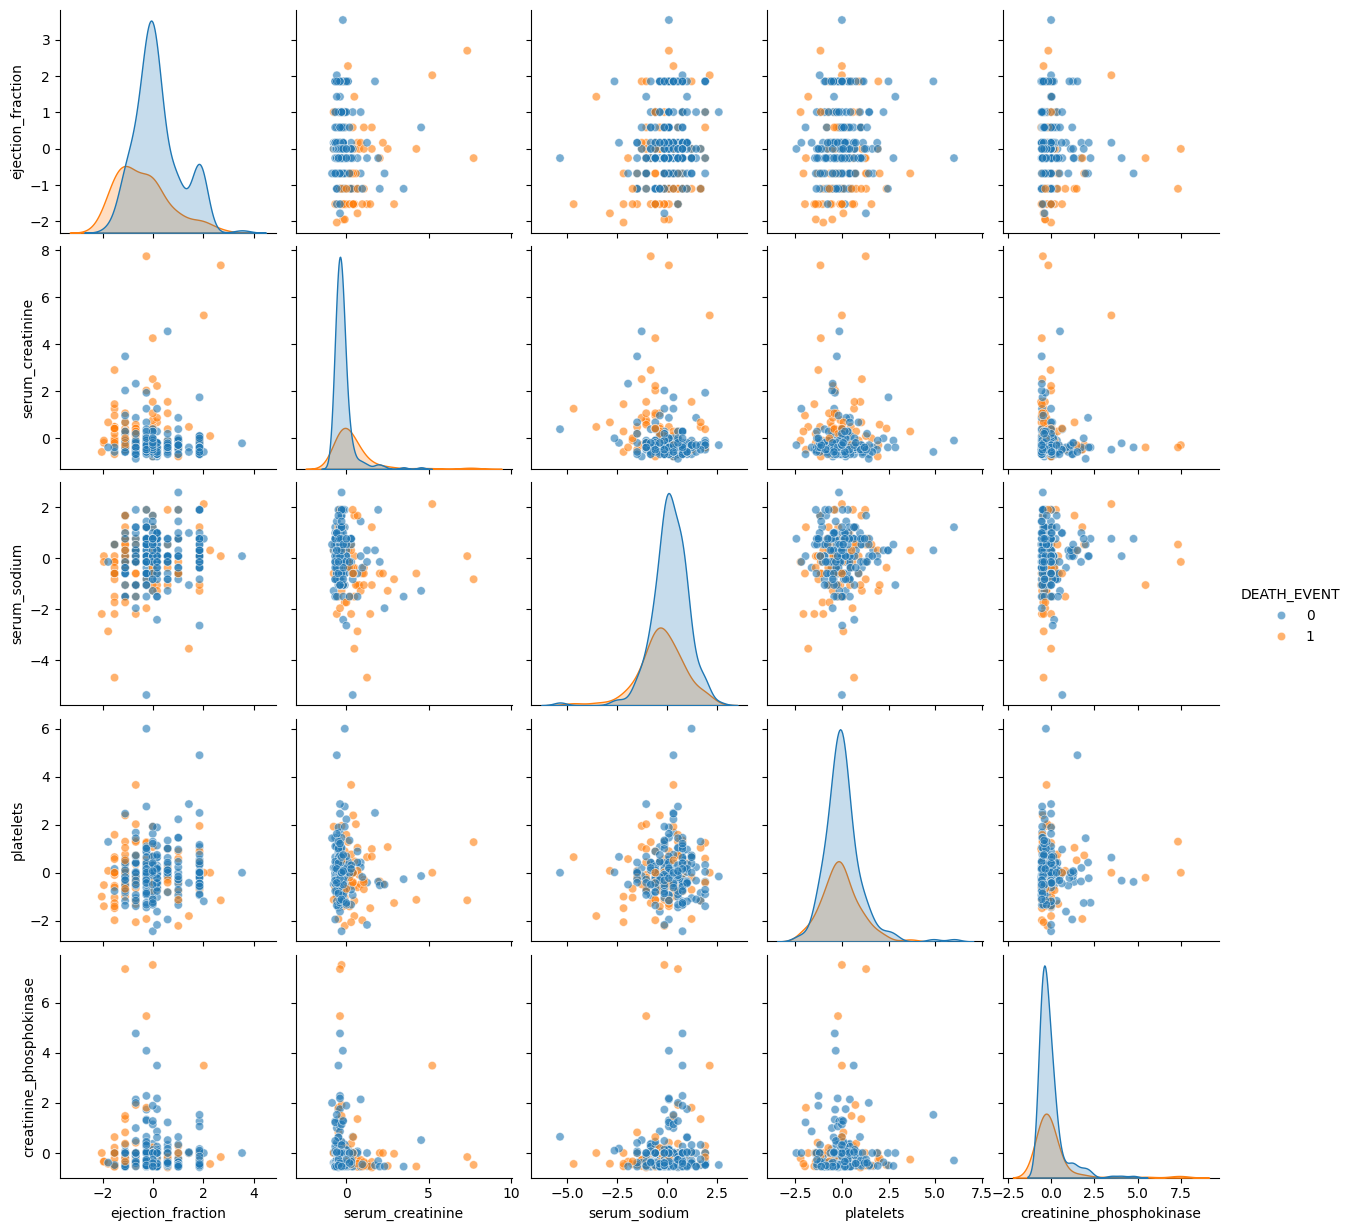

In [20]:
sns.pairplot(
    hf[["ejection_fraction", "serum_creatinine", 
         "serum_sodium", "platelets", "creatinine_phosphokinase", "DEATH_EVENT"]],
    hue="DEATH_EVENT",
    plot_kws={"alpha":0.6}
)
plt.show()


In [21]:
import pandas as pd
import numpy as np

# load data
hf = pd.read_csv("heart_failure_clinical_records_dataset.csv")

# grouping by age
bins = [-np.inf, 50, 60, 70, 80, np.inf]
labels = ["<50", "50-60", "60-70", "70-80", ">80"]
hf["age_group"] = pd.cut(hf["age"], bins=bins, labels=labels).astype("category")
hf["age_group_code"] = hf["age_group"].cat.codes  # 0,1,...,G-1
group_idx = hf["age_group_code"].values  # length n
G = hf["age_group_code"].nunique()

# don't include age in the predictors
hf = hf.drop(columns=["age"])

# continuous predictors & standardize 
cont = [
    "creatinine_phosphokinase",
    "ejection_fraction",
    "platelets",
    "serum_creatinine",
    "serum_sodium",
    "time"
]

for c in cont:
    hf[c] = (hf[c] - hf[c].mean()) / hf[c].std()

predictor_cols = [
    "anaemia",
    "creatinine_phosphokinase",
    "diabetes",
    "ejection_fraction",
    "high_blood_pressure",
    "platelets",
    "serum_creatinine",
    "serum_sodium",
    "sex",
    "smoking"]
    #"time" - we don't want the follow-up period duration to be one of the predictors,
      # as this is highly correlated with death event

X = hf[predictor_cols].values      
y = hf["DEATH_EVENT"].values.astype(int)

n, p = X.shape
print("n =", n, "p =", p, "G =", G)
# n = 299, p = 11 predictors, G = 5 age groups

# MODEL
# For patient i in age group j: y_ij ~ Bernoulli( logit^{-1}(eta_i) )

# Linear predictor: eta_i = a_{age_group[j]} + sum_k z_k * b_j * x_{ij}

# a_g: random intercept for age group g (captures baseline mortality per age group)
# b_j: coefficient for predictor j
# z_j = 0, 1: indicator

# Each vector z = (z_1, ..., z_p) defines one model and then the Bayesian model selection/averaging can take place.

# Priors:
# a_g ~ N(0, sigma_a^2) (random intercepts; hierarchy)
# b_j ~ N(0, tau^2) (prior on coefficients)
# z_j ~ Bernoulli(p) (prior over model space: which variables are likely included?)
#
# Hyperparameters:
tau = 2.0 # prior sd for b_j
sigma_alpha = 1.0 # prior sd for a_g
pi = 0.5 # prior each predictor

# Metropolis proposal standard deviations
s_beta = 3.0      
s_alpha = 3.0      

# MCMC settings
n_iter  = 15000     
burn_in = 5000      

# initialize
rng = np.random.default_rng(123)

# start with random model where each predictor included/excluded with prob 0.5
z = rng.integers(0, 2, size=p)             
# Draw b from prior
beta  = rng.normal(0, tau, size=p)             
# Random intercepts for each age group from prior
alpha = rng.normal(0, sigma_alpha, size=G)    

# log functions

def log_prior_beta(beta, tau):
    # log p(b) = sum_j log N(b_j | 0, tau^2)
    return -0.5 * np.sum((beta / tau)**2) - len(beta)*np.log(tau*np.sqrt(2*np.pi))

def log_prior_alpha(alpha, sigma_alpha):
    # log p(a) = sum_g log N(a_g | 0, sigma_a^2)
    return -0.5 * np.sum((alpha / sigma_alpha)**2) - len(alpha)*np.log(sigma_alpha*np.sqrt(2*np.pi))

def log_prior_z(z, pi):
    # log p(z) = sum_j [ z_j log π + (1 - z_j) log (1 - π) ]
    return np.sum(z*np.log(pi) + (1 - z)*np.log(1 - pi))

def log_likelihood(y, X, beta, alpha, z, group_idx):
    # log p(y | beta, alpha, z) = sum_i [ y_i eta_i - log(1 + exp(eta_i)) ]
    eta = alpha[group_idx] + (z * beta) @ X.T
    return np.sum(y * eta - np.log1p(np.exp(eta)))

def log_posterior(y, X, beta, alpha, z, group_idx, tau, sigma_alpha, pi):
    # Posterior = log p(beta, alpha, z | y, X) 
    return (log_likelihood(y, X, beta, alpha, z, group_idx)
            + log_prior_beta(beta, tau)
            + log_prior_alpha(alpha, sigma_alpha)
            + log_prior_z(z, pi))


# storing MCMC samples
z_samples = np.zeros((n_iter, p), dtype=int)
beta_samples = np.zeros((n_iter, p))
alpha_samples = np.zeros((n_iter, G))
lp_samples = np.zeros(n_iter)

# running counts for delta_{z_j}
z_counts = np.zeros(p)

# Acceptance counters - we need to tune the hyperparameters so that these rates to be around 0.2-0.5
z_accept = np.zeros(p)      
z_total  = np.zeros(p)       

beta_accept = np.zeros(p)     
beta_total  = np.zeros(p)    

alpha_accept = np.zeros(G)    
alpha_total  = np.zeros(G)

# METROPOLIS SAMPLER
for it in range(n_iter):

    # MODEL SELECTIOn
    for j in range(p):
        z_total[j] += 1 # track total z proposals

        # Prior inclusion probs for z_j -- purely Ber(0.5) for burn-in, then data-driven empirical for remaining samples
        if it < burn_in:
            prob = 0.5
        else:
            prob = z_counts[j] / (it - burn_in + 1)
            prob = max(0.01, min(0.99, prob)) # don't want degenerate proposals

        z_new = z.copy()
        z_new[j] = rng.binomial(1, prob)

        # MH acceptance ratio
        lp_old = log_posterior(y, X, beta, alpha, z, group_idx, tau, sigma_alpha, pi)
        lp_new = log_posterior(y, X, beta, alpha, z_new, group_idx, tau, sigma_alpha, pi)

        if np.log(rng.random()) < (lp_new - lp_old):
            z = z_new
            z_accept[j] += 1 # track accepted z proposals

    # after updating all z_j, we update running counts to keep track of empirical z_j=1
    if it >= burn_in:
        z_counts += z

    # Update beta_j | z_j
    for j in range(p):
        beta_total[j] += 1 # track total beta proposals
        
        beta_new = beta.copy()
        beta_new[j] = rng.normal(beta[j], s_beta)

        lp_old = log_posterior(y, X, beta, alpha, z, group_idx, tau, sigma_alpha, pi)
        lp_new = log_posterior(y, X, beta_new, alpha, z, group_idx, tau, sigma_alpha, pi)

        if np.log(rng.random()) < (lp_new - lp_old):
            beta = beta_new
            beta_accept[j] += 1 # track accepted beta proposals

    # Update random alpha_g (random intercept, hierarchical)
    for g in range(G):
        alpha_total[g] += 1
        
        alpha_new = alpha.copy()
        alpha_new[g] = rng.normal(alpha[g], s_alpha)

        lp_old = log_posterior(y, X, beta, alpha, z, group_idx, tau, sigma_alpha, pi)
        lp_new = log_posterior(y, X, beta, alpha_new, z, group_idx, tau, sigma_alpha, pi)

        if np.log(rng.random()) < (lp_new - lp_old):
            alpha = alpha_new
            alpha_accept[g] += 1 # track accepted alpha proposals


    # update the storage
    z_samples[it] = z
    beta_samples[it] = beta
    alpha_samples[it] = alpha
    lp_samples[it] = log_posterior(y, X, beta, alpha, z, group_idx, tau, sigma_alpha, pi)

print("\nAcceptance Rates:")

z_acc_rate = z_accept / z_total
print("\nZ acceptance rates (per predictor):")
for name, r in zip(predictor_cols, z_acc_rate):
    print(f"{name:25s}: {r:.3f}")

beta_acc_rate = beta_accept / beta_total
print("\nBeta acceptance rates (per coefficient):")
for name, r in zip(predictor_cols, beta_acc_rate):
    print(f"{name:25s}: {r:.3f}")

alpha_acc_rate = alpha_accept / alpha_total
print("\nAlpha acceptance rates (per age group):")
for g, r in zip(labels, alpha_acc_rate):
    print(f"Age group {g:5s}: {r:.3f}")

# posterior summaries for after burn-in
z_post = z_samples[burn_in:]
beta_post = beta_samples[burn_in:]
alpha_post = alpha_samples[burn_in:]

# Posterior inclusion probability for each predictor
incl_probs = z_post.mean(axis=0)

print("\nPosterior inclusion probabilities:")
for col, prob in zip(predictor_cols, incl_probs):
    print(f"{col:25s}: {prob: .3f}")

# Posterior predictive model-averaged probabilities
eta_post = alpha_post[:, group_idx] + (z_post * beta_post) @ X.T
p_post = 1 / (1 + np.exp(-eta_post))
p_mean = p_post.mean(axis=0)

print("\nFirst 10 posterior predictive death probabilities:")
print(p_mean[:10])

n = 299 p = 10 G = 5

Acceptance Rates:

Z acceptance rates (per predictor):
anaemia                  : 0.868
creatinine_phosphokinase : 0.853
diabetes                 : 0.867
ejection_fraction        : 0.825
high_blood_pressure      : 0.676
platelets                : 0.853
serum_creatinine         : 0.829
serum_sodium             : 0.860
sex                      : 0.850
smoking                  : 0.863

Beta acceptance rates (per coefficient):
anaemia                  : 0.560
creatinine_phosphokinase : 0.574
diabetes                 : 0.562
ejection_fraction        : 0.067
high_blood_pressure      : 0.463
platelets                : 0.572
serum_creatinine         : 0.075
serum_sodium             : 0.556
sex                      : 0.544
smoking                  : 0.569

Alpha acceptance rates (per age group):
Age group <50  : 0.111
Age group 50-60: 0.110
Age group 60-70: 0.106
Age group 70-80: 0.154
Age group >80  : 0.193

Posterior inclusion probabilities:
anaemia                  :  0

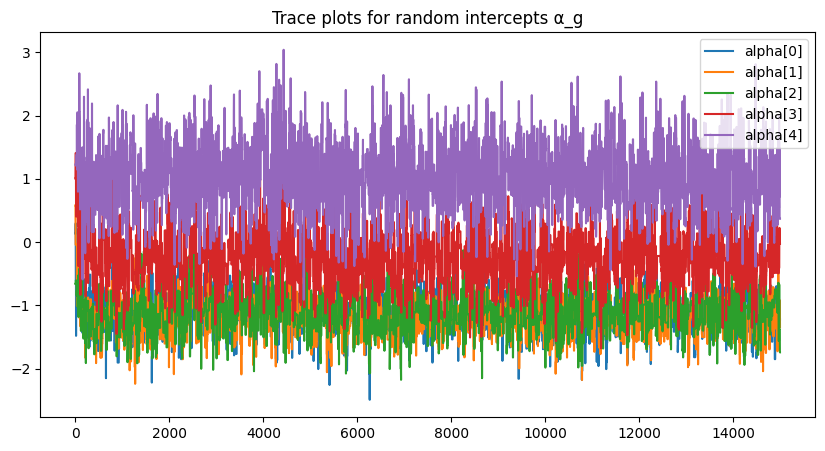

In [22]:
plt.figure(figsize=(10,5))
for g in range(G):
    plt.plot(alpha_samples[:, g], label=f"alpha[{g}]")
plt.legend()
plt.title("Trace plots for random intercepts α_g")
plt.show()

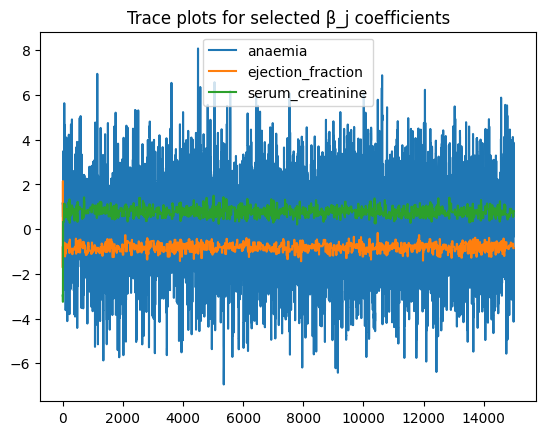

In [23]:
for j in [0, 3, 6]:   # example indices
    plt.plot(beta_samples[:, j], label=predictor_cols[j])
plt.legend()
plt.title("Trace plots for selected β_j coefficients")
plt.show()

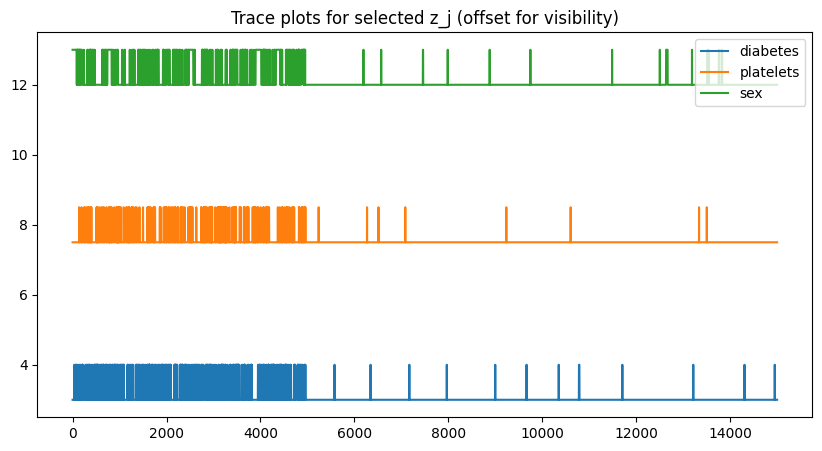

In [24]:
plt.figure(figsize=(10,5))
for j in [2, 5, 8]:  # example subset
    plt.plot(z_samples[:, j] + j*1.5, label=predictor_cols[j])
plt.title("Trace plots for selected z_j (offset for visibility)")
plt.legend()
plt.show()

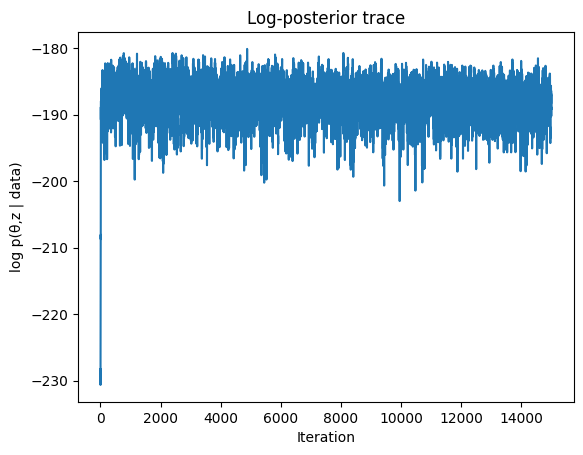

In [25]:
plt.plot(lp_samples)
plt.title("Log-posterior trace")
plt.xlabel("Iteration")
plt.ylabel("log p(θ,z | data)")
plt.show()

In [26]:
# after burn in samples
z_post = z_samples[burn_in:]       
beta_post = beta_samples[burn_in:]    
alpha_post = alpha_samples[burn_in:]   

S = z_post.shape[0]
n, p = X.shape

# posterior inclusion probabilities P(z_j=1 | y,X)
incl_probs = z_post.mean(axis=0)        

# model-averaged predicted probabilities for each patient
#   eta_s,i = alpha_s[g[i]] + sum_j z_sj * beta_sj * x_ij
eta_post = alpha_post[:, group_idx] + (z_post * beta_post) @ X.T  
p_post = 1 / (1 + np.exp(-eta_post))                            
p_mean = p_post.mean(axis=0)                                   


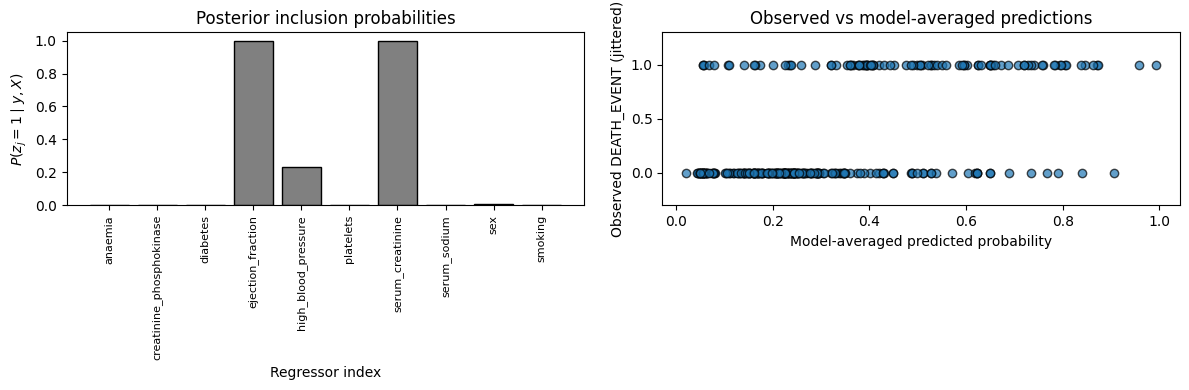

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# left fig
x_idx = np.arange(p)
ax1.bar(x_idx, incl_probs, color="gray", edgecolor="black")
ax1.set_xlabel("Regressor index")
ax1.set_ylabel(r"$P(z_j = 1 \mid y, X)$")
ax1.set_title("Posterior inclusion probabilities")

ax1.set_xticks(x_idx)
ax1.set_xticklabels(predictor_cols, rotation=90, fontsize=8)

# Right fig
ax2.scatter(p_mean, y, alpha=0.7, edgecolor="k")
ax2.set_xlabel("Model-averaged predicted probability")
ax2.set_ylabel("Observed DEATH_EVENT")
ax2.set_title("Observed vs model-averaged predictions")

# reference line at y=0 and y=1 bands
ax2.set_ylim(-0.3, 1.3)

plt.tight_layout()
plt.show()
